<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-load" data-toc-modified-id="Data-load-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data load</a></span><ul class="toc-item"><li><span><a href="#Item" data-toc-modified-id="Item-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Item</a></span></li><li><span><a href="#Dataset" data-toc-modified-id="Dataset-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Dataset</a></span></li><li><span><a href="#DataLoader" data-toc-modified-id="DataLoader-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>DataLoader</a></span></li></ul></li><li><span><a href="#Export" data-toc-modified-id="Export-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Export</a></span></li></ul></div>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-load" data-toc-modified-id="Data-load-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data load</a></span><ul class="toc-item"><li><span><a href="#Item" data-toc-modified-id="Item-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Item</a></span></li><li><span><a href="#Dataset" data-toc-modified-id="Dataset-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Dataset</a></span></li><li><span><a href="#DataLoader" data-toc-modified-id="DataLoader-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>DataLoader</a></span></li></ul></li><li><span><a href="#Export" data-toc-modified-id="Export-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Export</a></span></li></ul></div>

In [ ]:
#default_exp data.load

In [ ]:
#export
from mantisshrimp.imports import *
from mantisshrimp.core import *
from mantisshrimp.data.core import *
from mantisshrimp.data.annotation import *

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-load" data-toc-modified-id="Data-load-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data load</a></span><ul class="toc-item"><li><span><a href="#Item" data-toc-modified-id="Item-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Item</a></span></li><li><span><a href="#Dataset" data-toc-modified-id="Dataset-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Dataset</a></span></li><li><span><a href="#DataLoader" data-toc-modified-id="DataLoader-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>DataLoader</a></span></li></ul></li><li><span><a href="#Export" data-toc-modified-id="Export-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Export</a></span></li></ul></div>

# Data load
> Functions for creating a DataLoader

## Item

In [ ]:
#export
@dataclass
class Item:
    img:       np.ndarray
    iid:       int
    labels:    List[int]
    iscrowds:  List[int]
    bboxes:    List[BBox]=None
    masks:     Mask=None
#     keypoints: #TODO
    @classmethod
    def from_record(cls, r):
        return cls(
            img=open_img(r.iinfo.fp),
            iid=r.iinfo.iid,
            labels=r.annot.oids,
            iscrowds=r.annot.iscrowds,
            bboxes=r.annot.bboxes,
            masks=Mask.from_segs(r.annot.segs,r.iinfo.h,r.iinfo.w) if r.annot.segs else None,
            #keypoints: TODO
        )
    
    def asdict(self): return self.__dict__
    # TODO: This creates a copy, is that necessary?
    def replace(self, **kwargs): return dataclasses.replace(self, **kwargs)

In [ ]:
#export
def show_item(o, *, label=True, bbox=True, mask=True, catmap=None, ax=None):
    names = [catmap.i2o[i].name for i in o.labels] if notnone(catmap) else o.labels
    show_annot(im=o.img, ax=ax,
               labels=names if label else None,
               bboxes=o.bboxes if bbox else None,
               masks=o.masks if mask else None)

In [ ]:
catmap,rtrain,rvalid = test_utils.sample_records()


Removed 1 images that don't have annotations


In [ ]:
item = Item.from_record(rtrain[0])

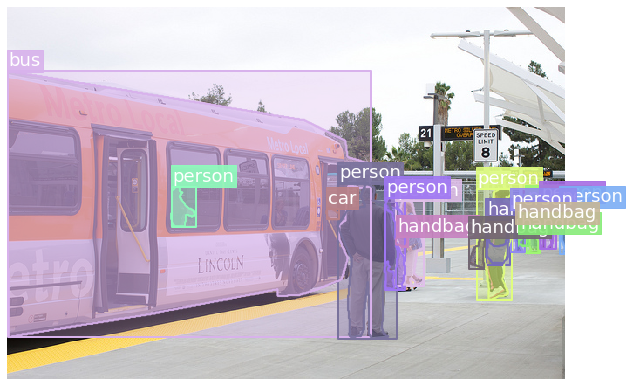

In [ ]:
show_item(item, catmap=catmap)

## Dataset

In [ ]:
#export
class Dataset:
    def __init__(self, records, tfm=None): self.records,self.tfm = records,tfm
    def __len__(self): return len(self.records)
        
    def __getitem__(self, i): return self._getitem(i=i)
    def _getitem(self, i):
        item = Item.from_record(self.records[i])
        return self.tfm(item) if notnone(self.tfm) else item
    
    def __repr__(self): return f'<{self.__class__.__name__} with {len(self.records)} items>'

In [ ]:
#export
def _sample_dsets(): 
    return catmap,Dataset(rtrain),Dataset(rvalid)
test_utils.sample_dsets = _sample_dsets

In [ ]:
catmap,train_ds,valid_ds = test_utils.sample_dsets()

In [ ]:
item = train_ds[0]

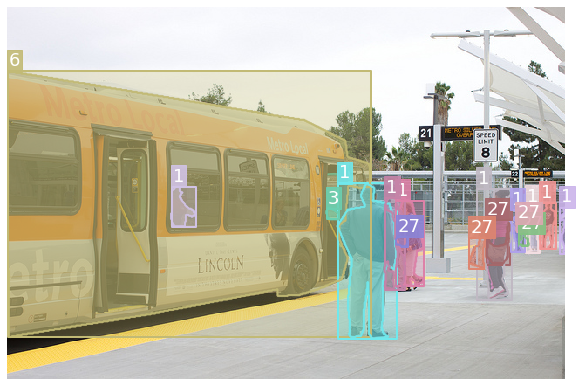

In [ ]:
show_annot(item.img, labels=item.labels, bboxes=item.bboxes, masks=item.masks)

## DataLoader

In [ ]:
#export
_fake_box = [0,1,2,3]

In [ ]:
#export
def _iid2tensor(iid): return tensor(iid, dtype=torch.int64)
def _labels2tensor(labels): return tensor(labels or [0], dtype=torch.int64)
def _iscrowds2tensor(vs): return tensor(vs or [0], dtype=torch.uint8)
def _bboxes2tensor(bxs): return tensor([o.xyxy for o in bxs] or [_fake_box], dtype=torch.float)
def _areas2tensor(bxs): return tensor([o.area for o in bxs] or [4])
def _masks2tensor(masks): return tensor(masks.data, dtype=torch.uint8)

In [ ]:
#export
def item2tensor(item):
    x = im2tensor(item.img)
    y = {
        'image_id': tensor(item.iid, dtype=torch.int64),
        'labels':   _labels2tensor(item.labels),
        'iscrowd':  _iscrowds2tensor(item.iscrowds),
        'boxes':    ifnotnone(item.bboxes, _bboxes2tensor),
        'area':     ifnotnone(item.bboxes, _areas2tensor),
        'masks':    ifnotnone(item.masks, _masks2tensor),
        # TODO: Keypoints
    }
    return x, cleandict(y)

In [ ]:
item = train_ds[0].replace(bboxes=[], labels=[], iscrowds=[])
x,y = item2tensor(item)
test_eq(y['boxes'], [tensor(_fake_box, dtype=torch.float)])
test_eq(y['labels'], [0])
test_eq(y['iscrowd'], [0])
test_eq(y['area'], [4])

In [ ]:
#export
def rcnn_collate(items):
    ts = [item2tensor(o) for o in items]
    return list(zip(*ts))

In [ ]:
#export
RCNNDataLoader = partial(DataLoader, collate_fn=rcnn_collate)

In [ ]:
#export
def _sample_dls():
    train_dl = RCNNDataLoader(train_ds, batch_size=2, shuffle=False, drop_last=False)
    valid_dl = RCNNDataLoader(valid_ds, batch_size=4, shuffle=False, drop_last=False)
    return catmap, train_dl, valid_dl
test_utils.sample_dls = _sample_dls

In [ ]:
dl = test_utils.sample_dls()[1]

In [ ]:
xb,yb = first(dl)

In [ ]:
test_eq(len(xb), 2)
test_eq(len(yb), 2)

In [ ]:
x = xb[0]
test_eq(x.shape, [3,427,640])
test_eq(isinstance(x, Tensor), True)

In [ ]:
y = yb[0]
test_eq_type(y['image_id'], tensor(0))
test_eq(allequal([isinstance(o, Tensor) for o in y.values()]), True)
test_eq(y['labels'], [ 6,  1,  1,  1,  1,  1,  1,  1, 27, 27,  1,  3, 27,  1, 27, 27])
test_eq(y['iscrowd'], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
test_eq(y['boxes'][0], [0.0000,  73.8900, 416.4400, 379.0200])
test_eq(y['masks'].shape, [16,427,640])
test_eq((y['masks']==0).all(), False)
test_eq(allequal(lmap(len, [y['labels'],y['iscrowd'],y['boxes'],y['masks']])), True)

# Export


In [ ]:
from nbdev.export import notebook2script
notebook2script()

Converted 00a_core.ipynb.
Converted 00b_lightning_core.ipynb.
Converted 01_layers.ipynb.
Converted 02_data.core.ipynb.
Converted 04_data.annotations.ipynb.
Converted 06_data.load.ipynb.
Converted 07_transforms.ipynb.
Converted 08_models.ipynb.
Converted 09_learner.ipynb.
Converted 11_metrics.core.ipynb.
Converted Untitled.ipynb.
Converted Untitled1.ipynb.
Converted data_refactor.ipynb.
Converted index.ipynb.
